# Emulator Schematic

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import cftime
import IPython
import matplotlib.pyplot as plt
import math

from mlde_utils import cp_model_rotated_pole
from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map, sorted_em_time_by_mean

In [ ]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

## Figure: Emulator Schematic

1.0


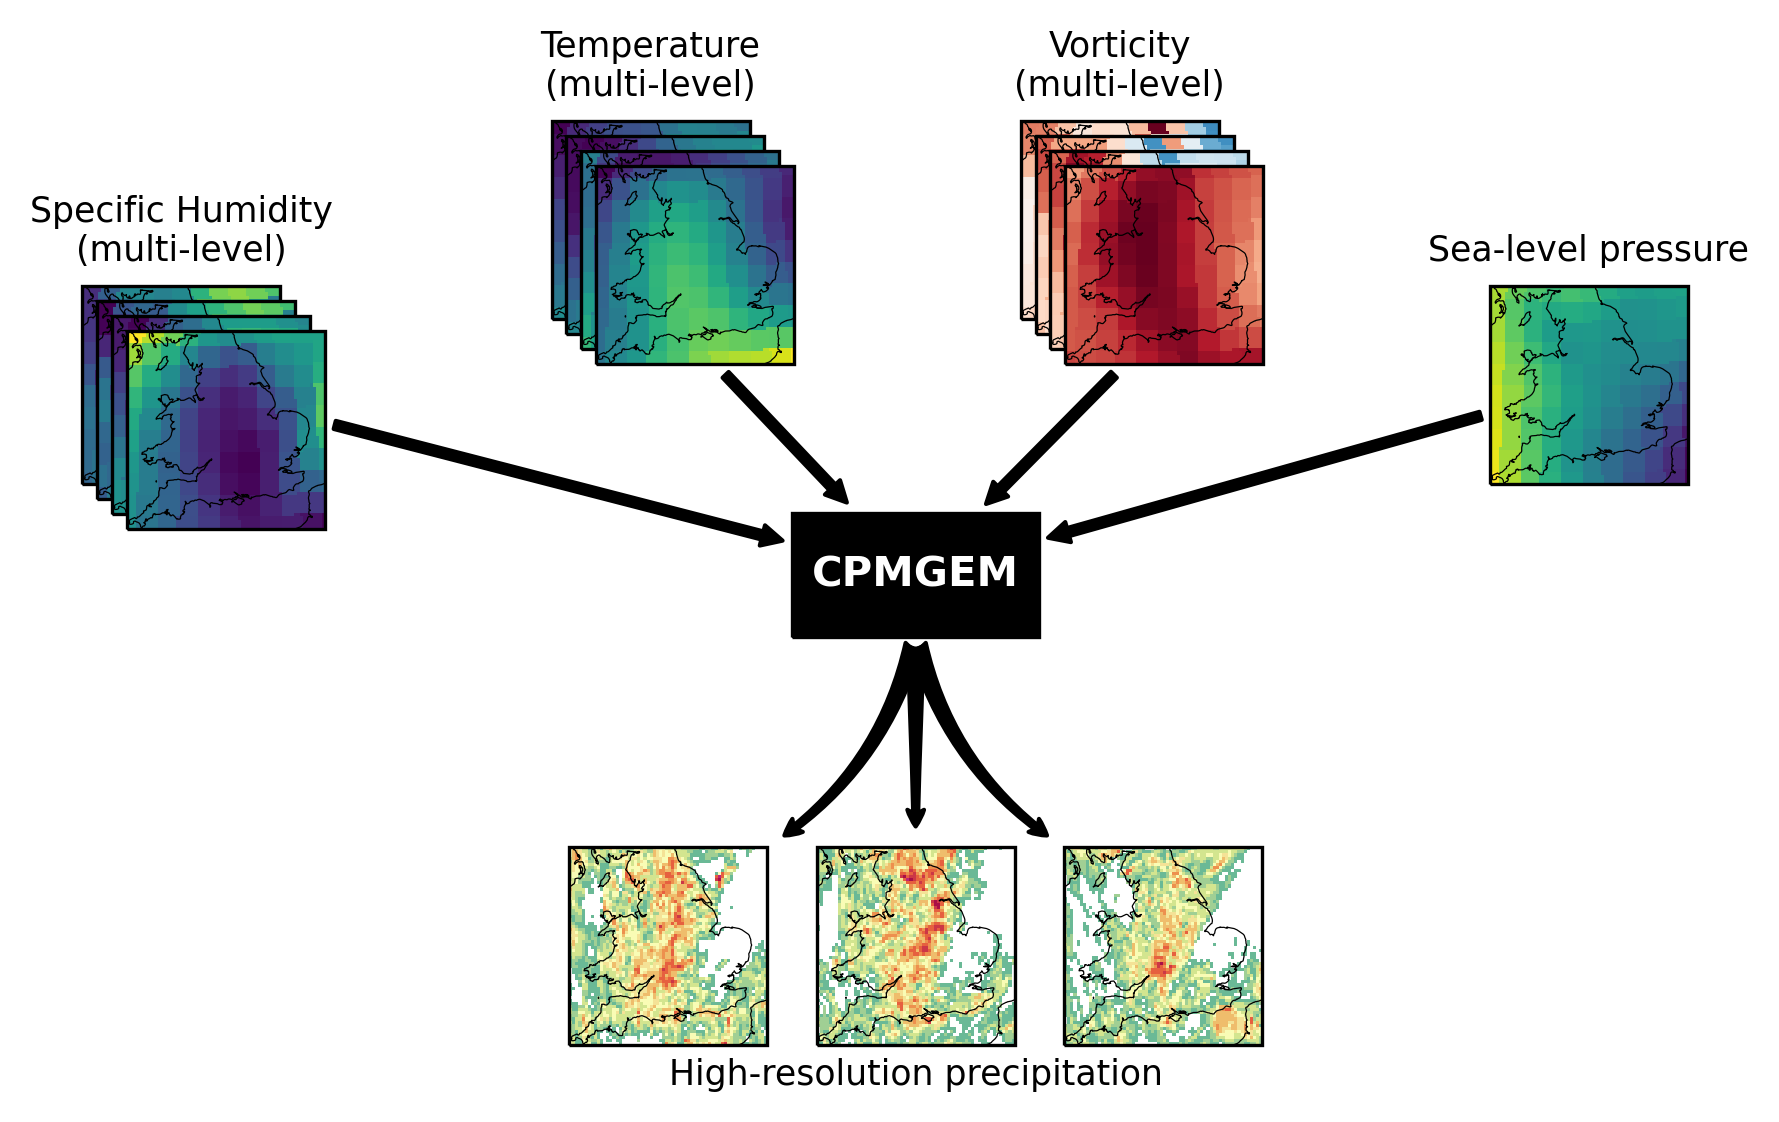

In [ ]:
em_time = ("01", cftime.Datetime360Day(1993, 8, 1, 12))

plot_ds = EVAL_DS["CPM"].sel(time=em_time[1], method="nearest").sel(ensemble_member=em_time[0]).sel(model=list(MODELS["CPM"].keys())[-1])
subplot_kw = dict(projection=cp_model_rotated_pole)

nsamples = 3

thetas = [850, 700, 500, 250]

possible_variables = [("spechum", thetas, "Specific Humidity\n(multi-level)"), ("temp", thetas, "Temperature\n(multi-level)"), ("vorticity", thetas, "Vorticity\n(multi-level)"), ("psl", [""], "Sea-level pressure")]
variables = list(filter(lambda v: any([k.startswith(v[0]) for k in plot_ds.variables.keys()]), possible_variables))

full_variable_set = [f"{varclass}{level}" for varclass, levels, _title in variables for level in levels]


awidth = 0.12
offset_width = 0.009
stacked_awidth = (awidth + offset_width *3)
gap = (1 - stacked_awidth * 4)/(len(variables) - 1)
print(stacked_awidth*4 + gap*3)

fig = plt.figure(figsize=(5.5, 5.5), layout="constrained")

axd = fig.subplot_mosaic([full_variable_set + [f"pred_pr {i}" for i in range(nsamples)] + ["AI"]], subplot_kw=subplot_kw)

ax = axd["AI"]
# ax.axis("off")
ax.set_facecolor('black')
ax.text(0.5, 0.5, "CPMGEM", 
        ha='center', va='center', color="white", weight='bold', transform=ax.transAxes)
ax.set_position([0.43, awidth+0.15, 0.15, 0.15])

output_arrows = [
    dict(
        xy=(1, 1),
        xytext=(0.5, 0),
        arrowprops=dict(facecolor='black', shrinkB=5, arrowstyle="fancy", connectionstyle="arc3,rad=-0.2"),
    ),
    dict(
        xy=(0.5, 1),
        xytext=(0.5, 0),
        arrowprops=dict(facecolor='black', shrinkB=5, arrowstyle="fancy"),
    ),
    dict(
        xy=(0, 1),
        xytext=(0.5, 0),
        arrowprops=dict(facecolor='black', shrinkB=5, arrowstyle="fancy", connectionstyle="arc3,rad=0.2"),
    ),
]
for sampleidx in range(nsamples):
    ax = axd[f"pred_pr {sampleidx}"]
    plot_map(plot_ds["pred_pr"].isel(sample_id=sampleidx), ax=ax, style="pr")
    ax.set_position([(0.505-awidth/2)+(sampleidx-1)*(awidth+0.03), awidth/2, awidth, awidth])

    if sampleidx == 1:
        ax.text(0.5, -0.15, "High-resolution precipitation", fontsize="small", ha='center', va='center',transform=ax.transAxes)

    axd["AI"].annotate(
            '',
            xycoords=ax.transAxes,
            textcoords=axd["AI"].transAxes,
            **output_arrows[sampleidx],
        )
arrows = [
    dict(
        xy=(0.5, 0.5),
        xytext=(0.5, 0.5),
        arrowprops=dict(facecolor='black', shrinkA=38, shrinkB=33, arrowstyle="simple"),#, connectionstyle="arc3,rad=0.2"),
    ),
    dict(
        xy=(0.5, 0.5),
        xytext=(0.85, -0.25),
        arrowprops=dict(facecolor='black', shrinkB=24, arrowstyle="simple"),#, connectionstyle="arc3,rad=0.2"),
    ),
    dict(
        xy=(0.5, 0.5),
        xytext=(0.5, -0.25),
        arrowprops=dict(facecolor='black', shrinkB=24, arrowstyle="simple"),#, connectionstyle="arc3,rad=-0.2"),
    ),
    dict(
        xy=(0.5, 0.5),
        xytext=(0.5, 0.5),
        arrowprops=dict(facecolor='black', shrinkA=27, shrinkB=33, arrowstyle="simple"),#, connectionstyle="arc3,rad=-0.2"),
    ),
]

for vi, (varclass, levels, vartitle) in enumerate(variables):
    variable_set = [f"{varclass}{level}" for level in levels]
    
    for i, var in enumerate(variable_set):
        ax = axd[var]
        var_plot_kwargs = {}
        if varclass in ["vorticity"]:
            var_plot_kwargs = {"center": 0}
        plot_map(plot_ds[var], ax=ax, style=None, **var_plot_kwargs)
        left = (stacked_awidth + gap) * vi + offset_width*i
        top = 0.5-offset_width*i
        if vi == 0 or vi == len(variables) - 1:
            top = top - 0.1
        ax.set_position([left, top, awidth, awidth]) 
        if i == 0:
            ax.set_title(vartitle, fontsize="small")
        if i == 0:#len(variable_set)-1:
            axd["AI"].annotate(
                '',
                xycoords=axd["AI"].transAxes,
                textcoords=ax.transAxes,
                **arrows[vi],
            )